#### Import Libraries

In [1]:
import os 
import sys
sys.path.append(os.path.join(os.getcwd(), '..', '..', 'ConvLSTM_PyTorch_master'))
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs

import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch import nn

from data_standarization import mean_std_scaler

from net_params_auto import convlstm_encoder_params, convlstm_decoder_params
from encoder import Encoder
from decoder import Decoder
from model import ED

from tqdm import tqdm

#### Upload data

In [2]:
frames_predict = 12
batch_size = 8
num_layers = 4
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
class ERA5_dataset(torch.utils.data.Dataset):

    def __init__(self):
        super(ERA5_dataset, self).__init__()

        # Define the path
        self.data_path = os.path.join(os.getcwd(), '..', '..', 'input_data', 'hourly')

        # Read the data
        self.data = xr.open_dataset(os.path.join(self.data_path, 'valid_data_hourly_m_s_2020_2020.nc'))['ws']

        #I order the coordinates
        coords = self.data.coords
        self.original_coords = {'time': coords['time'], 'latitude': coords['latitude'], 'longitude': coords['longitude']}
        self.dims = ["time", "latitude", "longitude"]
        
        self.data = np.array(self.data)
        self.data = torch.from_numpy(self.data).float()

        self.dataset_spatial_size = self.data.shape[-1]

        self.stats = xr.open_dataset(os.path.join(self.data_path, 'statistics_train_ds_per_pixel.nc'))
        self.mean = self.stats["mean"]
        self.std = self.stats["std"]

        self.mean = np.array(self.mean)
        self.mean = torch.from_numpy(self.mean).float()

        self.std = np.array(self.std)
        self.std = torch.from_numpy(self.std).float()
        
        self.data = mean_std_scaler(self.data, self.mean, self.std)
        
        #chunkify: That is, reshape data in an array where each element are a 3D cube of 12x144x144 
        # I calcule data.shape[0]/12)*12 so that the number of selected data are divisible by 12
        self.data = self.data[:int(self.data.shape[0]/frames_predict)*frames_predict].reshape((int(self.data.shape[0]/frames_predict), frames_predict, self.dataset_spatial_size, self.dataset_spatial_size))

        # (inputs are given as data[:-1], targets as data[1:])
        self.inputs = self.data[:-1]
        self.targets = self.data[1:]

        # I do the same transformations for the coordinats, specifically the time coordinate
        self.orig_coords_time = np.array(self.original_coords["time"])
        self.orig_coords_lon = np.array(self.original_coords["longitude"])
        self.orig_coords_lat = np.array(self.original_coords["latitude"])

        self.new_coords_time = self.orig_coords_time[:int(self.orig_coords_time.shape[0] / frames_predict) * frames_predict].reshape((int(self.orig_coords_time.shape[0] / frames_predict), frames_predict))

        input_coords_time = self.new_coords_time[:-1]
        target_coords_time = self.new_coords_time[1:]

        #input_coords_time = input_coords_time.reshape((int(input_coords_time.shape[0] * args.frames_predict)))
        #target_coords_time = target_coords_time.reshape((int(target_coords_time.shape[0] * args.frames_predict)))

        #self.input_coords = {'time': input_coords_time, 'latitude': coords['latitude'], 'longitude': coords['longitude']}
        #self.target_coords = {'time': target_coords_time, 'latitude': coords['latitude'], 'longitude': coords['longitude']}

        #print('input/target division done.')

        self.dataset = TensorDataset(*(self.inputs, self.targets, self.targets))
            
    def __getitem__(self, index):
        input = self.dataset.tensors[0][index]
        target = self.dataset.tensors[1][index]
        sup = self.dataset.tensors[2][index]
        
        return input, target, sup, index
    
    #return dataset length
    def __len__(self):
        return len(self.dataset)

In [4]:
data = ERA5_dataset()

dataLoader = DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=20)


#### Uplaod Model

In [5]:
model_path = os.path.join(os.getcwd(), '..', '..', 'experiments', 'convlstm_mae_4_PerPixel_mean-std_hourly_100_epochs_FP12', 'models', 'ckpt')

In [6]:
def load_model():

    encoder_params = convlstm_encoder_params(num_layers, input_len=frames_predict, device=device)
    decoder_params = convlstm_decoder_params(num_layers, output_len=frames_predict, device=device)

    encoder = Encoder(encoder_params[0], encoder_params[1]).to(device)
    decoder = Decoder(decoder_params[0], decoder_params[1], num_layers).to(device)
    
    net = ED(encoder, decoder)

    if torch.cuda.device_count() > 1:
        net = nn.DataParallel(net)
    
    net.to(device)

    torch.cuda.empty_cache()

    # Loading model
    model_info = torch.load(os.path.join(model_path, 'checkpoint_50.pth.tar'), map_location=device)
        
    net.load_state_dict(model_info['state_dict'])

    return net 

In [7]:
model = load_model()
print('ConvLSTM Model loaded successfully')

/tmp/ipykernel_208039/99982798.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_info = torch.load(os.path.join(model_path, 'checkpoint_50.pth.tar'), map_location=d

ConvLSTM Model loaded successfully


#### Occlusion sensitivity function

In [8]:
def occlusion_sensitivity(net, input_sequence, patch_size=8, occlusion_value=0.0, output_frame=None):
    """
    Occlusion sensitivity calculation for an individual sample

    Parameters:
    - model: PyTorch model (ConvLSTM)
    - input_sequence: Pytorch tensor with the correct shape (batch, time_steps, channels, H, W)
    - patch_size: Size of the patch to occlude
    - occlusion_value: value used in the patch
    - output_frame: Specific output frame to analyze (if None, considers all)

    Return:
    - importance_map: Importance map of this individual sample
    """

    net.eval() 
    with torch.no_grad():

        # Create channels dimension
        input_sequence = input_sequence.unsqueeze(2)

        # Obtain the prediction
        preds = net(input_sequence).detach().cpu()#.numpy()

        B, T, C, H, W = input_sequence.shape  

        importance_map = torch.zeros((B, T, C, H, W)).to('cpu')

        # Iterate over each time step
        #for t in range(T):
            #print('Timestamp: ', t)
            #print()
        for t in tqdm(range(T), desc="Processing timesteps"):
            #iterate over the image size
            for i in range(0, H, patch_size):
                #print(i)
                for j in range(0, W, patch_size):
                    # Clone the original input sequence
                    occluded_sequence = input_sequence.clone()

                    # Occlude the corresponding path in the input_secuence
                    occluded_sequence[:, t, :, i:i+patch_size, j:j+patch_size] = occlusion_value

                    # Obtain the prediction with the occluded sequence
                    preds_occ = net(occluded_sequence).detach().cpu()#.numpy()

                    # Calcule the difference (exemple: norma L2)
                    #diff = np.linalg.norm(preds - preds_occ)
                    if output_frame is not None:
                        diff = (preds[:, output_frame] - preds_occ[:, output_frame]) ** 2
                        diff = torch.sqrt(torch.sum(diff, dim=(1, 2, 3)))
                        
                    else:
                        diff = (preds - preds_occ) ** 2
                        diff = torch.sqrt(torch.sum(diff, dim=(1, 2, 3, 4)))

                    # Assing the occluded value to the corresponding place in the importance map
                    importance_map[:, t, :, i:i+patch_size, j:j+patch_size] = diff[:, None, None, None]
                    #importance_maps[:, t, i:i+patch_size, j:j+patch_size] += diff

    del occluded_sequence
    torch.cuda.empty_cache()

    return importance_map.squeeze(2).numpy(), preds

In [9]:
# input_sequence: (batch=1, time_steps=12, channels=1, H=144, W=144)
# Create an iterator over the dataloader
data_iter = iter(dataLoader)  

In [10]:
# Extract an individual batch and select one single sample
batch = 0
batch_data = next(data_iter)[1].to(device)
input_sequence = batch_data[batch:batch+1]

#### Applaying model occlusion sensitivity

In [11]:
# Possible patch sizes: 3, 8, 16, 18, 36, 72
importance_map_occlusion, preds = occlusion_sensitivity(model, input_sequence, patch_size=8)#, output_frame=0)

Processing timesteps: 100%|██████████| 12/12 [02:45<00:00, 13.79s/it]


#### Visualize the importance map

In [12]:
def plot_importance_maps(data, coords):
    plt.style.use('default')
    
    fig = plt.figure(figsize=(10, 5))
    
    cmap = 'viridis'
    
    #central_lon, central_lat = -2.6, 38.7
    extent = [-9.8, 4.5, 31.6, 45.9]
    
    #ax = fig.add_subplot(3,2,(2,6), projection=ccrs.Orthographic(central_lon, central_lat))
    fig, axes = plt.subplots(3, 4, figsize=(15, 10), subplot_kw={'projection': ccrs.Mercator()})

    lon, lat = np.meshgrid(coords['longitude'], coords['latitude'])
    horizon = data.shape[0]

    for time, ax in enumerate(axes.flatten()):

        vmin, vmax = data[time].min(), data[time].max()

        ax.set_extent([-10.3, 5, 31, 46.4])
        gls = ax.gridlines(alpha=0.5, draw_labels=True, dms=True)
        gls.right_labels = False
        gls.top_labels = False
        ax.coastlines(resolution='10m', color='white')
    
        #im0 = ax.imshow(importance_map[batch, t], cmap=cmap, interpolation='lanczos', vmin=vmin, vmax=vmax, extent=extent, transform=ccrs.PlateCarree())
        im0 = ax.pcolormesh(lon, lat, data[time], cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
        cbar0 = plt.colorbar(im0,ax=ax,fraction=0.046, pad=0.04)
        cbar0.set_label(label=r'Importance',size=14, labelpad=10)
        if horizon != time:
            ax.set_title(f"Hour -{horizon - time - 1}")
        else:
            ax.set_title(f"Hour {horizon - time - 1}")
        #ax.axis("off")

    plt.tight_layout()
    plt.show()
    plt.close()

<Figure size 1000x500 with 0 Axes>

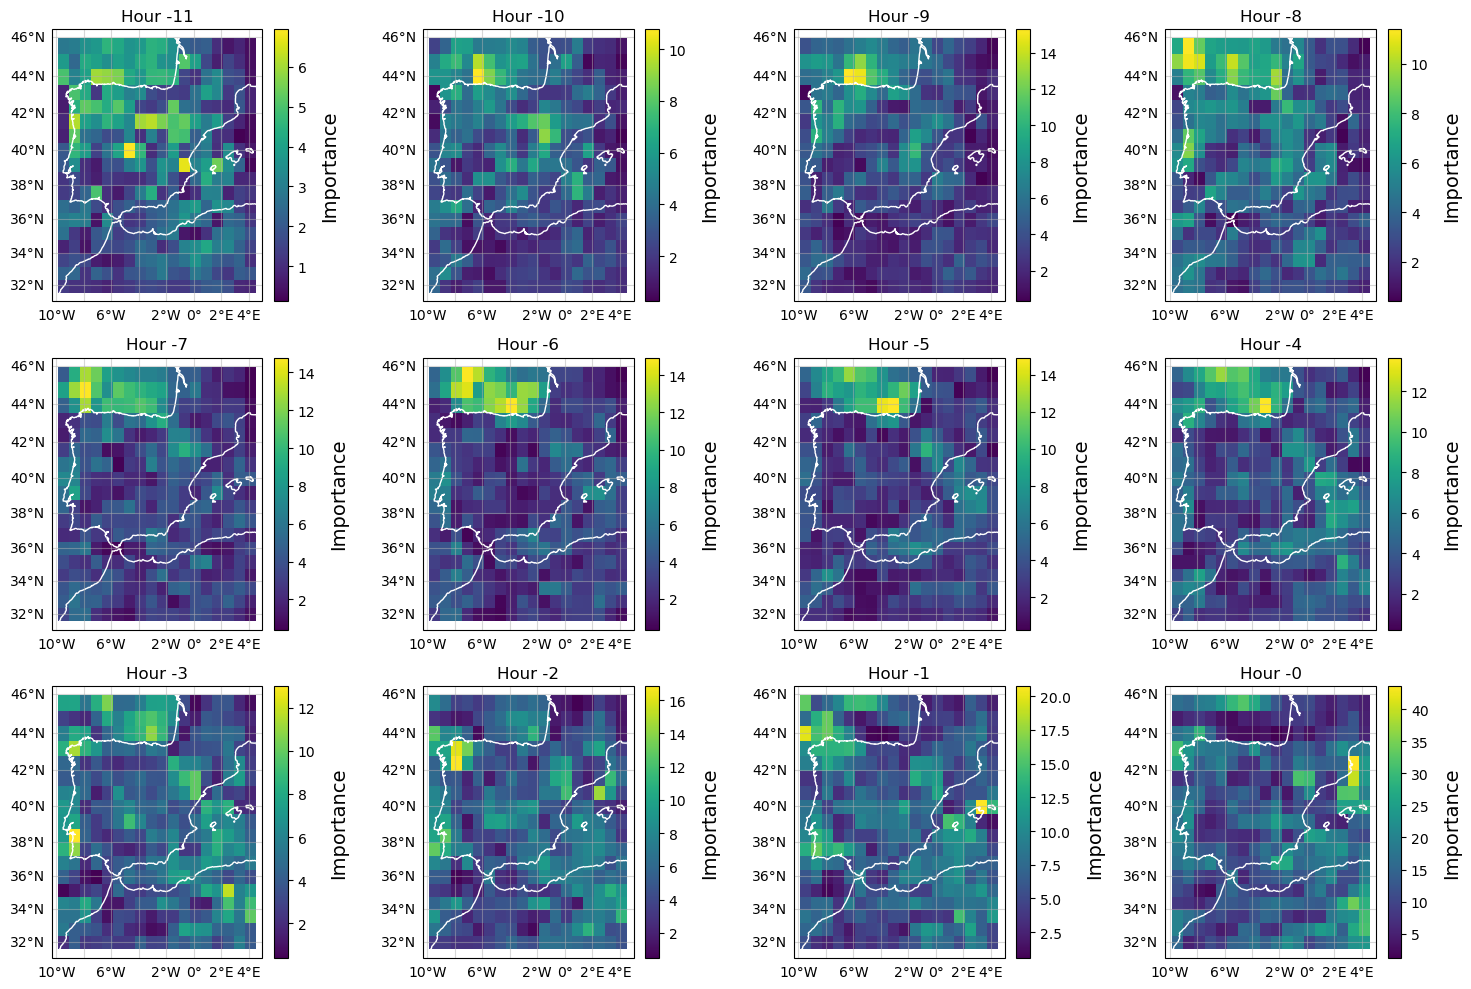

In [13]:
batch = 5

plot_importance_maps(importance_map_occlusion[0], coords=data.original_coords)

In [14]:
def plot_prediction_vs_importance_maps(input, preds, importance, coords):
    plt.style.use('default')    
    cmap = 'viridis'
    
    #central_lon, central_lat = -2.6, 38.7
    extent = [-9.8, 4.5, 31.6, 45.9]
    
    #ax = fig.add_subplot(3,2,(2,6), projection=ccrs.Orthographic(central_lon, central_lat))
    fig, axes = plt.subplots(12, 3, figsize=(15, 45), subplot_kw={'projection': ccrs.Mercator()})

    datasets = [input, preds, importance]
    lon, lat = np.meshgrid(coords['longitude'], coords['latitude'])
    horizon = preds.shape[0]

    # Añadir subtítulos de las columnas
    col_titles = ['Input', 'Prediction', 'Importance']
    for col, title in enumerate(col_titles):
        fig.text(0.2 + col*0.35, 1, title, ha='center', va='center', fontsize=14, fontweight='bold')

    for col, data in enumerate(datasets):
        for row in range(12):
            ax = axes[row, col]
            vmin, vmax = data[row].min(), data[row].max()
            
            ax.set_extent([-10.3, 5, 31, 46.4])
            gls = ax.gridlines(alpha=0.5, draw_labels=True, dms=True)
            gls.right_labels = False
            gls.top_labels = False
            ax.coastlines(resolution='10m', color='white')
        
            im = ax.pcolormesh(lon, lat, data[row], cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
            cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            
            if col == 2:
                cbar.set_label(label='Importance', size=10, labelpad=5)
            else:
                cbar.set_label(label='Wind Speed (m/s)', size=10, labelpad=5)

            if col == 1:
                ax.set_title(f"Hour {row}")
            else:
                ax.set_title(f"Hour -{11 - row}")

    plt.tight_layout()
    plt.show()
    plt.close()

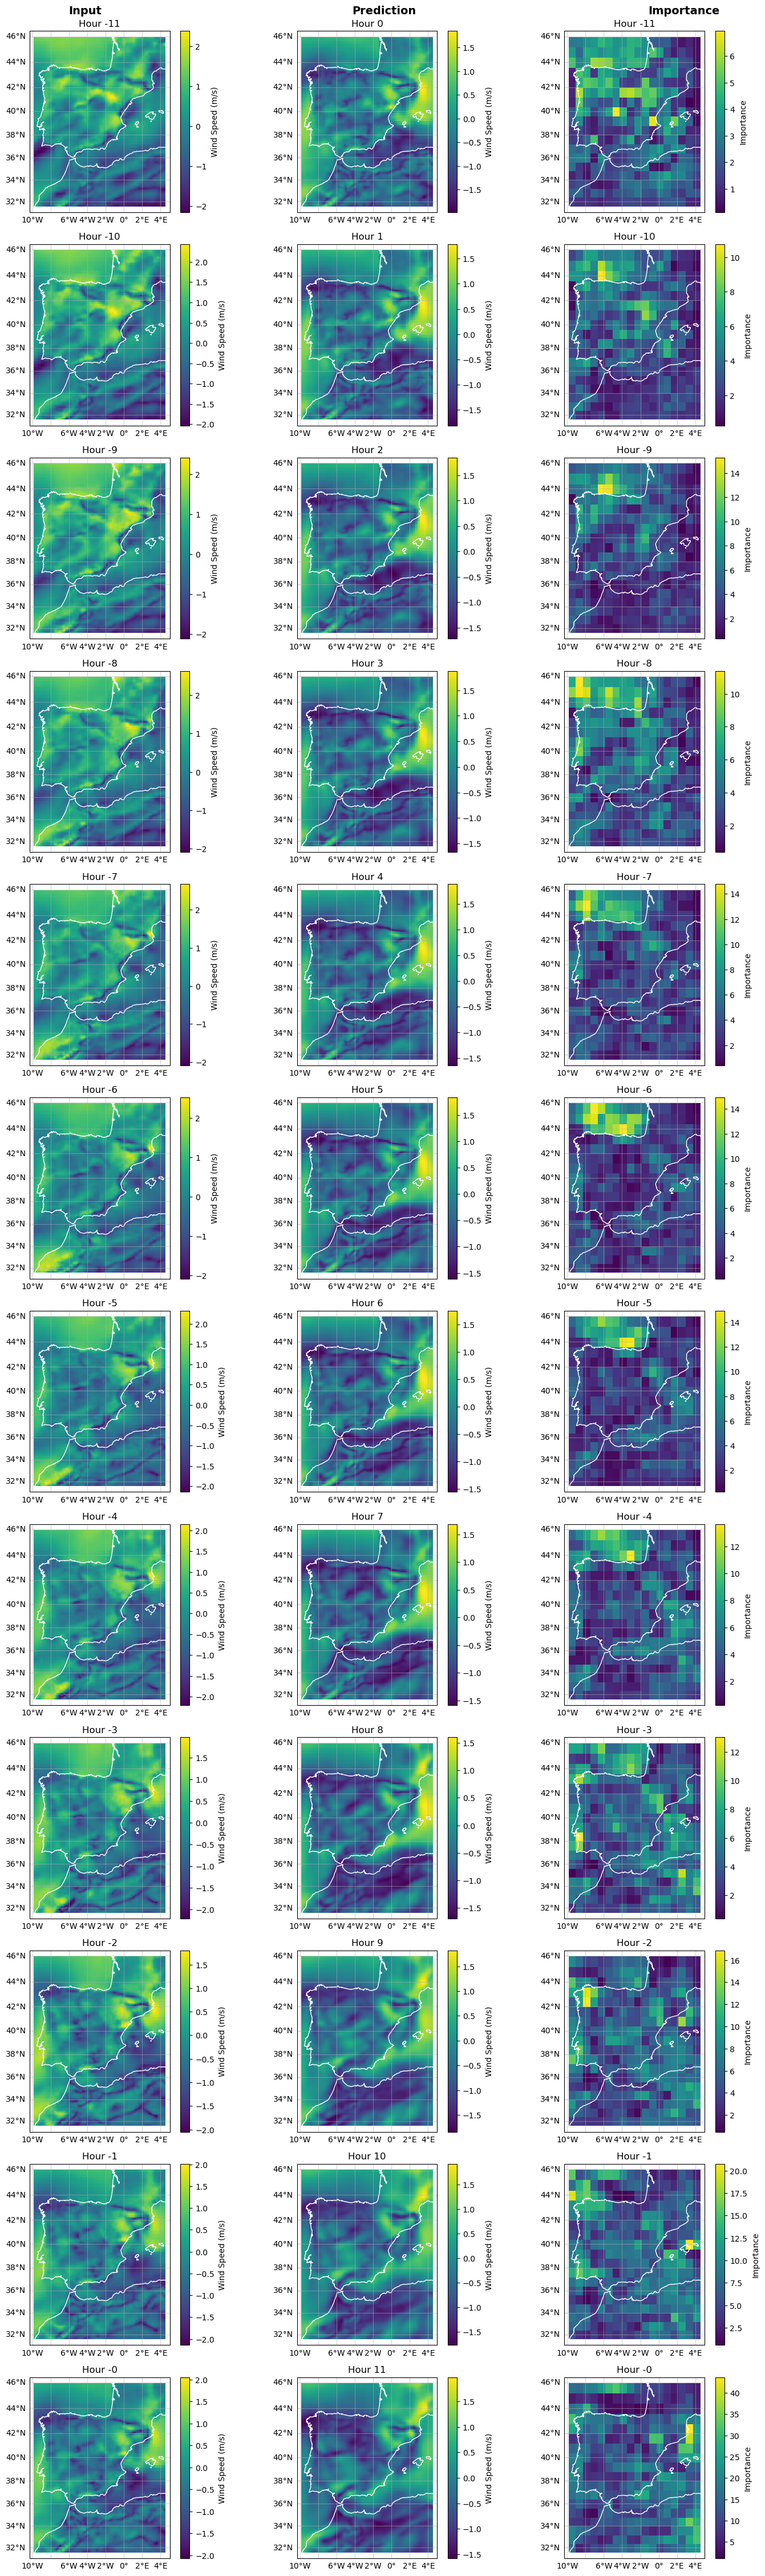

In [15]:
plot_prediction_vs_importance_maps(input_sequence[0].squeeze(1).to('cpu'), preds[0].squeeze(1).to('cpu'), importance_map_occlusion[0], coords=data.original_coords)

### Integrate the importance per map

In [16]:
def plot_integrate_map(data, log = True):

    integrated_data = np.sum(data, axis=(1, 2))
    x_values = -11 + np.arange(len(integrated_data))

    plt.figure(figsize=(8, 5))
    plt.plot(x_values, integrated_data, marker='o', linestyle='-', color='b', label="Suma por frame")

    # Etiquetas y título
    plt.xlabel("Input time stamp")
    plt.ylabel("Importance")
    if log:
        plt.yscale("log")
    plt.title("Importance per timestamp")
    plt.legend()
    plt.grid(True)

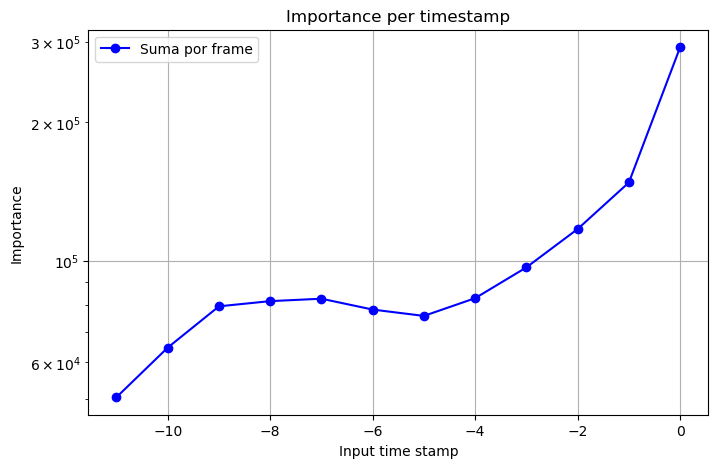

In [17]:
plot_integrate_map(importance_map_occlusion[0], log=True)